In [7]:
from PIL import Image
import numpy as np
import cv2
import random

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from dall_e  import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown

import matplotlib.pyplot as plt
%matplotlib inline

target_image_size = 256

def preprocess(img):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)

def load_anno():
    video_dir = '/home/lr/dataset/YouTube-VOS/2018/train/JPEGImages'
    list_path = '/home/lr/dataset/YouTube-VOS/2018/youtube2018_train_list.txt'

    samples = []

    with open(list_path, 'r') as f:
        for idx, line in enumerate(f.readlines()):
            sample = dict()
            vname, num_frames = line.strip('\n').split()
            sample['frames_path'] = sorted(glob.glob(osp.join(video_dir, vname, '*.jpg')))
            sample['num_frames'] = int(num_frames)
            samples.append(sample)
    return samples

def visualize_vqvae(z1_q, z2_q, frame1, frame2, x_rec1, x_rec2):
    frame_vq_1 = z1_q.permute(1,2,0).numpy()
    frame_vq_2 = z2_q.permute(1,2,0).numpy()


    frame_vq_1 = (frame_vq_1 * 255 / 8192).astype(np.uint8)
    frame_vq_2 = (frame_vq_2 * 255 / 8192).astype(np.uint8)

    v1 = cv2.applyColorMap(frame_vq_1, cv2.COLORMAP_JET)
    v2 = cv2.applyColorMap(frame_vq_2, cv2.COLORMAP_JET)


    plt.rcParams['figure.dpi'] = 200

    plt.figure()
    plt.subplot(3,2,1)
    plt.imshow(v1)
    plt.subplot(3,2,2)
    plt.imshow(v2)

    plt.subplot(3,2,3)
    plt.imshow(np.array(frame1))

    plt.subplot(3,2,4)
    plt.imshow(np.array(frame2))

    plt.subplot(3,2,5)
    plt.imshow(np.array(x_rec1))

    plt.subplot(3,2,6)
    plt.imshow(np.array(x_rec2))

    plt.show()

def visualize_correspondence(z1_q, z2_q, sample_idx, frame1, frame2):
    plt.rcParams['figure.dpi'] = 200

    z1_q = z1_q[0].numpy()
    z2_q = z2_q[0].numpy()
    find = False
    count = 0

    while not find:
        x, y = sample_idx % 32, sample_idx // 32

        query = z1_q[y,x]
        m = (z2_q == query).astype(np.uint8) * 255
        count += 1

        if m.max() > 1:
            find = True
        else:
            sample_idx = random.randint(0, 32*32 -1)
            print('not find, change query')
        
    print(f"find correspodence at {count}")   

    querys_map = np.zeros((32,32))
    querys_map[y,x] = 255
    querys_map = querys_map.astype(np.uint8)
    querys_map = cv2.applyColorMap(querys_map, cv2.COLORMAP_JET)
    matches_map = cv2.applyColorMap(m, cv2.COLORMAP_JET)

    plt.figure()
    plt.subplot(2,2,1)
    plt.imshow(querys_map)
    plt.subplot(2,2,2)
    plt.imshow(matches_map)

    plt.subplot(2,2,3)
    plt.imshow(np.array(frame1))

    plt.subplot(2,2,4)
    plt.imshow(np.array(frame2))

In [8]:
# build model
# This can be changed to a GPU, e.g. 'cuda:0'.
dev = torch.device('cpu')

# For faster load times, download these files locally and use the local paths instead.
enc = load_model("/home/lr/models/vqvae/dalle/encoder.pkl", dev)
dec = load_model("/home/lr/models/vqvae/dalle/decoder.pkl", dev)

In [9]:
# sample frame
import os.path as osp
import glob

# samples = load_anno()

# video_idx = random.randint(0, len(samples) - 1)
# frame_idx = random.randint(0, samples[video_idx]['num_frames'] - 2)
# sample = samples[video_idx]
# frame1 = Image.open(sample['frames_path'][frame_idx]).convert('RGB')
# frame2 = Image.open(sample['frames_path'][frame_idx+1]).convert('RGB')
# print('sample frames from {}'.format(sample['frames_path'][0]))


frame1 = Image.open('/home/lr/dataset/YouTube-VOS/2019/train/JPEGImages/0358b938c1/00220.jpg').convert('RGB')
frame2 = Image.open('/home/lr/dataset/YouTube-VOS/2019/train/JPEGImages/0358b938c1/00225.jpg').convert('RGB')


x1 = preprocess(frame1)
x2 = preprocess(frame2)

from IPython.display import display, display_markdown

frame1 = T.ToPILImage(mode='RGB')(x1[0])
frame2 = T.ToPILImage(mode='RGB')(x2[0])

In [10]:
# encode and decode for dalle
z_logits1 = enc(x1)
z1_q = torch.argmax(z_logits1, axis=1)

z1 = F.one_hot(z1_q, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()
x_stats1 = dec(z1).float()
x_rec1 = unmap_pixels(torch.sigmoid(x_stats1[:, :3]))
x_rec1 = T.ToPILImage(mode='RGB')(x_rec1[0])

z_logits2 = enc(x2)
z2_q = torch.argmax(z_logits2, axis=1)

z2 = F.one_hot(z2_q, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()
x_stats2 = dec(z2).float()
x_rec2 = unmap_pixels(torch.sigmoid(x_stats2[:, :3]))
x_rec2 = T.ToPILImage(mode='RGB')(x_rec2[0])

In [11]:
# encode and decode for origin vqvae
from vqvae import VQVAE
model = VQVAE(downsample=4, n_embed=2048)
model = model.cuda()
en, quant, diff, ind, embed = model.encode(x1.cuda())

4


not find, change query
not find, change query
find correspodence at 3


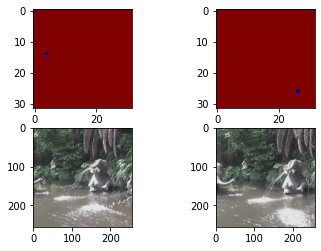

In [12]:
# visualize corr for dalle
sample_idx = random.randint(0, 32*32 -1)
visualize_correspondence(z1_q, z2_q, sample_idx, frame1, frame2)